<a href="https://colab.research.google.com/github/eisbetterthanpi/pytorch/blob/main/kimhc6028_curiousity_next.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### setup

In [11]:
# # https://github.com/kimhc6028/pytorch-noreward-rl
# https://stackoverflow.com/questions/67808779/running-gym-atari-in-google-colab
%pip install -U gym
%pip install -U gym[atari,accept-rom-license]

# !pip install gym[box2d]
# import gym


# # https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/54f5097c720c6f2656219ab14a4e7431/mario_rl_tutorial.ipynb
# import gym
# from gym.spaces import Box
# from gym.wrappers import FrameStack
# from nes_py.wrappers import JoypadSpace
# import gym_super_mario_bros

# env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
# env = JoypadSpace(env, [["right"], ["right", "A"]])

!pip install gym-super-mario-bros nes-py
# https://github.com/Kautenja/gym-super-mario-bros
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
# env = gym_super_mario_bros.make('SuperMarioBros-v0')
# env = JoypadSpace(env, SIMPLE_MOVEMENT)



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### model

In [ ]:
# model.py
# https://github.com/kimhc6028/pytorch-noreward-rl/blob/master/model.py
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

def normalized_columns_initializer(weights, std=1.0):
    out = torch.randn(weights.size())
    # out *= std / torch.sqrt(out.pow(2).sum(1).expand_as(out))
    out *= std / torch.sqrt(out.pow(2).sum(1).unsqueeze(dim=1).expand_as(out))
    return out

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        weight_shape = list(m.weight.data.size())
        fan_in = np.prod(weight_shape[1:4])
        fan_out = np.prod(weight_shape[2:4]) * weight_shape[0]
        w_bound = np.sqrt(6. / (fan_in + fan_out))
        m.weight.data.uniform_(-w_bound, w_bound)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        weight_shape = list(m.weight.data.size())
        fan_in = weight_shape[1]
        fan_out = weight_shape[0]
        w_bound = np.sqrt(6. / (fan_in + fan_out))
        m.weight.data.uniform_(-w_bound, w_bound)
        m.bias.data.fill_(0)


class ActorCritic(torch.nn.Module):
    def __init__(self, num_inputs, action_space):
        super(ActorCritic, self).__init__()
        self.in_dim = num_inputs # mario (240, 256)
        self.conv1 = nn.Conv2d(num_inputs[0], 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.lstm = nn.LSTMCell(num_inputs[1], 256)
        # self.lstm = nn.LSTMCell(32 * 10, 256)
        num_outputs = action_space.n
        self.critic_linear = nn.Linear(256, 1)
        self.actor_linear = nn.Linear(256, num_outputs)
        ################################################################
        self.icm_conv1 = nn.Conv2d(num_inputs[0], 32, 3, stride=2, padding=1)
        self.icm_conv2 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.icm_conv3 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.icm_conv4 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        #self.icm_lstm = nn.LSTMCell(32 * 3 * 3, 256)
        self.inverse_linear1 = nn.Linear(num_inputs[1] + num_inputs[1], 256)
        # self.inverse_linear1 = nn.Linear(320 + 320, 256)
        self.inverse_linear2 = nn.Linear(256, num_outputs)
        self.forward_linear1 = nn.Linear(num_inputs[1] + num_outputs, 256)
        # self.forward_linear1 = nn.Linear(320 + num_outputs, 256)
        self.forward_linear2 = nn.Linear(256, num_inputs[1])
        # self.forward_linear2 = nn.Linear(256, 320)
        #self.inverse_linear1 = nn.Linear(256 + 256, 256)
        #self.inverse_linear2 = nn.Linear(256, num_outputs)

        #self.forward_linear1 = nn.Linear(256 + num_outputs, 256)
        #self.forward_linear2 = nn.Linear(256, 256)
        ################################################################
        self.apply(weights_init)
        self.inverse_linear1.weight.data = normalized_columns_initializer(self.inverse_linear1.weight.data, 0.01)
        self.inverse_linear1.bias.data.fill_(0)
        self.inverse_linear2.weight.data = normalized_columns_initializer(self.inverse_linear2.weight.data, 1.0)
        self.inverse_linear2.bias.data.fill_(0)
        
        self.forward_linear1.weight.data = normalized_columns_initializer(self.forward_linear1.weight.data, 0.01)
        self.forward_linear1.bias.data.fill_(0)
        self.forward_linear2.weight.data = normalized_columns_initializer(self.forward_linear2.weight.data, 1.0)
        self.forward_linear2.bias.data.fill_(0)
        '''
        self.icm_lstm.bias_ih.data.fill_(0)
        self.icm_lstm.bias_hh.data.fill_(0)
        '''
        ################################################################
        self.actor_linear.weight.data = normalized_columns_initializer(self.actor_linear.weight.data, 0.01)
        self.actor_linear.bias.data.fill_(0)
        self.critic_linear.weight.data = normalized_columns_initializer(self.critic_linear.weight.data, 1.0)
        self.critic_linear.bias.data.fill_(0)
        self.lstm.bias_ih.data.fill_(0)
        self.lstm.bias_hh.data.fill_(0)
        self.train()


    def forward(self, inputs, icm):
        if icm == False: #A3C
            inputs, (a3c_hx, a3c_cx) = inputs # [1, 210, 160, 3], ([1, 256], [1, 256])
            x = F.elu(self.conv1(inputs)) # [1, 32, 80, 2]
            x = F.elu(self.conv2(x)) # [1, 32, 40, 1]
            x = F.elu(self.conv3(x)) # [1, 32, 20, 1]
            x = F.elu(self.conv4(x)) # [1, 32, 10, 1] mario[1, 32, 16, 1]
            print("x4",x.shape) # mario[2, 256]
            x = x.view(-1, self.in_dim[1])
            
            print("xv",x.shape)
            # x = x.view(-1, 32 * 10)
            print("wrthf",x.shape, a3c_hx.shape, a3c_cx.shape) # [2, 256], [1, 256], [1, 256]

            a3c_hx, a3c_cx = self.lstm(x, (a3c_hx, a3c_cx))
            x = a3c_hx
            critic = self.critic_linear(x)
            actor = self.actor_linear(x)
            # print("forward A3C ",critic.shape, actor.shape, a3c_hx.shape, a3c_cx.shape)
            return critic, actor, (a3c_hx, a3c_cx) # [1, 1], [1, 18], ([1, 256], [1, 256])

        else: #icm
            s_t, s_t1, a_t = inputs
            # s_t1=s_t1.float()
            # print("###s t###",s_t.dtype) # [1, 210, 160, 3] torch.float32

            '''
            s_t, (icm_hx, icm_cx) = s_t
            s_t1, (icm_hx1, icm_cx1) = s_t1
            '''
            vec_st = F.elu(self.icm_conv1(s_t))
            vec_st = F.elu(self.icm_conv2(vec_st))
            vec_st = F.elu(self.icm_conv3(vec_st))
            vec_st = F.elu(self.icm_conv4(vec_st))
            
            vec_st1 = F.elu(self.icm_conv1(s_t1))
            vec_st1 = F.elu(self.icm_conv2(vec_st1))
            vec_st1 = F.elu(self.icm_conv3(vec_st1))
            vec_st1 = F.elu(self.icm_conv4(vec_st1))
            vec_st = vec_st.view(-1, self.in_dim[1])
            vec_st1 = vec_st1.view(-1, self.in_dim[1])
            # vec_st = vec_st.view(-1, 32 * 10) # [1, 320] torch.float32
            # vec_st1 = vec_st1.view(-1, 32 * 10) # [1, 320] torch.float32

            #icm_hx, icm_cx = self.icm_lstm(vec_st, (icm_hx, icm_cx))
            #icm_hx1, icm_cx1 = self.icm_lstm(vec_st1, (icm_hx1, icm_cx1))
            #vec_st = icm_hx
            #vec_st1 = icm_hx1
            inverse_vec = torch.cat((vec_st, vec_st1), 1)
            forward_vec = torch.cat((vec_st, a_t), 1)
            inverse = self.inverse_linear1(inverse_vec)
            inverse = F.relu(inverse)
            inverse = self.inverse_linear2(inverse)
            inverse = F.softmax(inverse)
            forward = self.forward_linear1(forward_vec)
            forward = F.relu(forward)
            forward = self.forward_linear2(forward)
            # print("forward icm ",vec_st1.shape, inverse.shape, forward.shape)
            return vec_st1, inverse, forward # [1, 320], [1, 18], [1, 320]
            #return vec_st1, inverse, forward, (icm_hx, icm_cx), (icm_hx1, icm_cx1)


#### model simple

In [ ]:
# model.py
# https://github.com/kimhc6028/pytorch-noreward-rl/blob/master/model.py
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

def normalized_columns_initializer(weights, std=1.0):
    out = torch.randn(weights.size())
    out *= std / torch.sqrt(out.pow(2).sum(1).unsqueeze(dim=1).expand_as(out))
    return out

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        weight_shape = list(m.weight.data.size())
        fan_in = np.prod(weight_shape[1:4])
        fan_out = np.prod(weight_shape[2:4]) * weight_shape[0]
        w_bound = np.sqrt(6. / (fan_in + fan_out))
        m.weight.data.uniform_(-w_bound, w_bound)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        weight_shape = list(m.weight.data.size())
        fan_in = weight_shape[1]
        fan_out = weight_shape[0]
        w_bound = np.sqrt(6. / (fan_in + fan_out))
        m.weight.data.uniform_(-w_bound, w_bound)
        m.bias.data.fill_(0)


class ActorCritic(torch.nn.Module):
    def __init__(self, num_inputs, action_space):
        super(ActorCritic, self).__init__()
        # self.lstm = nn.LSTMCell(32 * 3 * 3, 256)
        ################################################################
        #self.icm_lstm = nn.LSTMCell(32 * 3 * 3, 256)
        #self.inverse_linear1 = nn.Linear(256 + 256, 256)
        #self.inverse_linear2 = nn.Linear(256, num_outputs)

        #self.forward_linear1 = nn.Linear(256 + num_outputs, 256)
        #self.forward_linear2 = nn.Linear(256, 256)
        ################################################################
        self.apply(weights_init)
        self.inverse_linear1.weight.data = normalized_columns_initializer(self.inverse_linear1.weight.data, 0.01)
        self.inverse_linear1.bias.data.fill_(0)
        self.inverse_linear2.weight.data = normalized_columns_initializer(self.inverse_linear2.weight.data, 1.0)
        self.inverse_linear2.bias.data.fill_(0)
        
        self.forward_linear1.weight.data = normalized_columns_initializer(self.forward_linear1.weight.data, 0.01)
        self.forward_linear1.bias.data.fill_(0)
        self.forward_linear2.weight.data = normalized_columns_initializer(self.forward_linear2.weight.data, 1.0)
        self.forward_linear2.bias.data.fill_(0)
        '''
        self.icm_lstm.bias_ih.data.fill_(0)
        self.icm_lstm.bias_hh.data.fill_(0)
        '''
        ################################################################
        self.actor_linear.weight.data = normalized_columns_initializer(self.actor_linear.weight.data, 0.01)
        self.actor_linear.bias.data.fill_(0)
        self.critic_linear.weight.data = normalized_columns_initializer(self.critic_linear.weight.data, 1.0)
        self.critic_linear.bias.data.fill_(0)
        self.lstm.bias_ih.data.fill_(0)
        self.lstm.bias_hh.data.fill_(0)
        self.train()


class ActorCritic(torch.nn.Module):
    def __init__(self, num_inputs, action_space):
        super(ActorCritic, self).__init__()
        self.in_dim = num_inputs # mario (240, 256)
        self.conv = nn.Sequential(
            nn.Conv2d(num_inputs[0], 32, 3, stride=2, padding=1), nn.ELU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ELU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ELU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ELU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ELU(), # added for RuntimeError: Input batch size 2 doesn't match hidden0 batch size 1
            )
        self.icm_conv = nn.Sequential(
            nn.Conv2d(num_inputs[0], 32, 3, stride=2, padding=1), nn.ELU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ELU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ELU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ELU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ELU(), # added for cat
            )
        self.lstm = nn.LSTMCell(num_inputs[1], 256)
        num_outputs = action_space.n
        self.critic_linear = nn.Linear(256, 1)
        self.actor_linear = nn.Linear(256, num_outputs)

        self.inverse_linear1 = nn.Linear(num_inputs[1] + num_inputs[1], 256)
        self.inverse_linear2 = nn.Linear(256, num_outputs)

        self.forward_linear1 = nn.Linear(num_inputs[1] + num_outputs, 256)
        self.forward_linear2 = nn.Linear(256, num_inputs[1])

    def forward(self, inputs, icm):
        if icm == False: #A3C
            inputs, (a3c_hx, a3c_cx) = inputs # [1, 210, 160, 3], ([1, 256], [1, 256])
            x = self.conv(inputs).view(-1, self.in_dim[1])
            a3c_hx, a3c_cx = self.lstm(x, (a3c_hx, a3c_cx))
            x = a3c_hx
            critic = self.critic_linear(x)
            actor = self.actor_linear(x)
            # print("forward A3C ",critic.shape, actor.shape, a3c_hx.shape, a3c_cx.shape)
            return critic, actor, (a3c_hx, a3c_cx) # [1, 1], [1, 18], ([1, 256], [1, 256])

        else: #icm
            s_t, s_t1, a_t = inputs
            '''
            s_t, (icm_hx, icm_cx) = s_t
            s_t1, (icm_hx1, icm_cx1) = s_t1
            '''
            vec_st = self.icm_conv(s_t).view(-1, self.in_dim[1])
            vec_st1 = self.icm_conv(s_t1).view(-1, self.in_dim[1])
            #icm_hx, icm_cx = self.icm_lstm(vec_st, (icm_hx, icm_cx))
            #icm_hx1, icm_cx1 = self.icm_lstm(vec_st1, (icm_hx1, icm_cx1))
            #vec_st = icm_hx
            #vec_st1 = icm_hx1
            inverse_vec = torch.cat((vec_st, vec_st1), 1)
            forward_vec = torch.cat((vec_st, a_t), 1)

            inverse = self.inverse_linear1(inverse_vec)
            inverse = F.relu(inverse)
            inverse = self.inverse_linear2(inverse)
            inverse = F.softmax(inverse)

            forward = self.forward_linear1(forward_vec)
            forward = F.relu(forward)
            forward = self.forward_linear2(forward)
            # print("forward icm ",vec_st1.shape, inverse.shape, forward.shape)
            return vec_st1, inverse, forward # [1, 320], [1, 18], [1, 320]
            #return vec_st1, inverse, forward, (icm_hx, icm_cx), (icm_hx1, icm_cx1)


#### model simplier

In [12]:
# model.py
# https://github.com/kimhc6028/pytorch-noreward-rl/blob/master/model.py
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"

class ActorCritic(torch.nn.Module):
    def __init__(self, in_shape, action_space):
        super(ActorCritic, self).__init__()
        self.in_dim = in_shape # mario (240, 256)
        self.conv = nn.Sequential( # A3C pi
            nn.Conv2d(in_shape[0], 32, 3, stride=2, padding=1), nn.ELU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ELU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ELU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ELU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ELU(), # added for RuntimeError: Input batch size 2 doesn't match hidden0 batch size 1
            )
        self.icm_conv = nn.Sequential( # ICM embed phi
            nn.Conv2d(in_shape[0], 32, 3, stride=2, padding=1), nn.ELU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ELU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ELU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ELU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ELU(), # added for cat
            )
        self.lstm = nn.LSTMCell(in_shape[1], 256)
        num_outputs = action_space.n
        self.critic_linear = nn.Linear(256, 1) # -> value
        self.actor_linear = nn.Linear(256, num_outputs) # -> action

        self.inv_linear = nn.Sequential( # inv learning, predict at
            nn.Linear(in_shape[1] + in_shape[1], 256), nn.ReLU(),
            nn.Linear(256, num_outputs), nn.Softmax()
            ) # cat(phi(st), phi(st+1)) -> athat
        self.fwd_linear = nn.Sequential( # predict phi st+1
            nn.Linear(in_shape[1] + num_outputs, 256), nn.ReLU(),
            nn.Linear(256, in_shape[1])
            ) # cat(phi(st), at) -> phihat(st+1)

    def forward(self, inputs, icm):
        if icm == False: #A3C
            inputs, (a3c_hx, a3c_cx) = inputs # [1, 210, 160, 3], ([1, 256], [1, 256])
            x = self.conv(inputs).view(-1, self.in_dim[1])
            a3c_hx, a3c_cx = self.lstm(x, (a3c_hx, a3c_cx))
            x = a3c_hx
            critic = self.critic_linear(x)
            actor = self.actor_linear(x)
            # print("forward A3C ",critic.shape, actor.shape, a3c_hx.shape, a3c_cx.shape)
            return critic, actor, (a3c_hx, a3c_cx) # [1, 1], [1, 18], ([1, 256], [1, 256])

        else: #icm
            s_t, s_t1, a_t = inputs
            '''
            s_t, (icm_hx, icm_cx) = s_t
            s_t1, (icm_hx1, icm_cx1) = s_t1
            '''
            vec_st = self.icm_conv(s_t).view(-1, self.in_dim[1])
            vec_st1 = self.icm_conv(s_t1).view(-1, self.in_dim[1])
            #icm_hx, icm_cx = self.icm_lstm(vec_st, (icm_hx, icm_cx))
            #icm_hx1, icm_cx1 = self.icm_lstm(vec_st1, (icm_hx1, icm_cx1))
            #vec_st = icm_hx
            #vec_st1 = icm_hx1
            inverse_vec = torch.cat((vec_st, vec_st1), 1)
            forward_vec = torch.cat((vec_st, a_t), 1)
            inverse = self.inv_linear(inverse_vec)
            forward = self.fwd_linear(forward_vec)
            # print("forward icm ",vec_st1.shape, inverse.shape, forward.shape)
            return vec_st1, inverse, forward # [1, 320], [1, 18], [1, 320]
            #return vec_st1, inverse, forward, (icm_hx, icm_cx), (icm_hx1, icm_cx1)


#### perceiverio

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
!pip install perceiver-pytorch

In [ ]:
from perceiver_pytorch import PerceiverIO
# https://github.com/lucidrains/perceiver-pytorch
actor = PerceiverIO(
    dim = env.observation_space.shape[0]*env.observation_space.shape[1],                    # dimension of sequence to be encoded
    queries_dim = env.action_space,            # dimension of decoder queries
    logits_dim = None,            # dimension of final logits
    depth = 6,                   # depth of net
    num_latents = 64,           # number of latents, or induced set points, or centroids. different papers giving it different names
    latent_dim = 64,            # latent dimension
    cross_heads = 1,             # number of heads for cross attention. paper said 1
    latent_heads = 4,            # number of heads for latent self attention, 8
    cross_dim_head = 16,         # number of dimensions per cross attention head
    latent_dim_head = 16,        # number of dimensions per latent self attention head
    weight_tie_layers = False    # whether to weight tie layers (optional, as indicated in the diagram)
).to(device)

critic = PerceiverIO(
    dim = env.observation_space.shape[0]*env.observation_space.shape[1],                    # dimension of sequence to be encoded
    queries_dim = env.action_space,            # dimension of decoder queries
    logits_dim = None,            # dimension of final logits
    depth = 6,                   # depth of net
    num_latents = 64,           # number of latents, or induced set points, or centroids. different papers giving it different names
    latent_dim = 64,            # latent dimension
    cross_heads = 1,             # number of heads for cross attention. paper said 1
    latent_heads = 4,            # number of heads for latent self attention, 8
    cross_dim_head = 16,         # number of dimensions per cross attention head
    latent_dim_head = 16,        # number of dimensions per latent self attention head
    weight_tie_layers = False    # whether to weight tie layers (optional, as indicated in the diagram)
).to(device)

lstm = PerceiverIO(
    dim = 256,                    # dimension of sequence to be encoded
    queries_dim = 256,            # dimension of decoder queries
    logits_dim = None,            # dimension of final logits
    depth = 6,                   # depth of net
    num_latents = 64,           # number of latents, or induced set points, or centroids. different papers giving it different names
    latent_dim = 64,            # latent dimension
    cross_heads = 1,             # number of heads for cross attention. paper said 1
    latent_heads = 4,            # number of heads for latent self attention, 8
    cross_dim_head = 16,         # number of dimensions per cross attention head
    latent_dim_head = 16,        # number of dimensions per latent self attention head
    weight_tie_layers = False    # whether to weight tie layers (optional, as indicated in the diagram)
).to(device)



    def forward(self, inputs, icm):
        if icm == False: #A3C
            inputs, (a3c_hx, a3c_cx) = inputs # [1, 210, 160, 3], ([1, 256], [1, 256])


            x = F.elu(self.conv4(x)) # [1, 32, 10, 1]
            # x = x.view(-1, 32 * 3 * 3)
            x = x.view(-1, 32 * 10)

            a3c_hx, a3c_cx = self.lstm(x, (a3c_hx, a3c_cx))

            return critic, actor, (a3c_hx, a3c_cx) # [1, 1], [1, 18], ([1, 256], [1, 256])

        else: #icm
            s_t, s_t1, a_t = inputs
            # s_t1=s_t1.float()
            # print("###s t###",s_t.dtype) # [1, 210, 160, 3] torch.float32


            return vec_st1, inverse, forward # [1, 320], [1, 18], [1, 320]



NameError: ignored

#### train

In [7]:
# train.py
# https://github.com/kimhc6028/pytorch-noreward-rl/blob/master/train.py
import math, os, sys, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import time

def ensure_shared_grads(model, shared_model):
    for param, shared_param in zip(model.parameters(), shared_model.parameters()):
        if shared_param.grad is not None:
            return
        shared_param._grad = param.grad

def train(rank, args, shared_model, optimizer=None):
    torch.manual_seed(seed + rank)
    # env = gym.make(env_name)
    env = gym_super_mario_bros.make('SuperMarioBros-v0')
    env = JoypadSpace(env, SIMPLE_MOVEMENT)
    
    # num_outputs = env.action_space.n
    model = ActorCritic(env.observation_space.shape, env.action_space)
    if optimizer is None:
        optimizer = optim.Adam(shared_model.parameters(), lr)
    model.train()
    state = env.reset()
    # state=state[:,:,0]
    state = torch.from_numpy(state.copy()).type(torch.float) # i added, change from int to float

    done = True
    episode_length = 0
    while True:
    # for x in range(num_episodes):
        episode_length += 1
        # Sync with the shared model
        # model.load_state_dict(shared_model.state_dict())
        if done:
            cx = torch.zeros(1, 256)
            hx = torch.zeros(1, 256)
        else:
            cx = cx.data
            hx = hx.data
        values = []
        log_probs = []
        rewards = []
        entropies = []
        inverses = []
        forwards = []
        actions = []
        vec_st1s = []

        # print("#####www####",state.dtype,hx.dtype)
        for step in range(num_steps):
            # print("#####www####",Variable(state.unsqueeze(0)).dtype,(state.unsqueeze(0).dtype))
            value, logit, (hx, cx) = model((state.unsqueeze(0), (hx, cx)), icm = False)
            s_t = state
            # print("logit.size",logit.shape) # [1, 6]
            prob = F.softmax(logit, dim=1)
            log_prob = F.log_softmax(logit, dim=1)
            entropy = -(log_prob * prob).sum(1)
            entropies.append(entropy)
            # action = prob.multinomial().data
            action = prob.multinomial(1).data
            log_prob = log_prob.gather(1, action)
            oh_action = torch.Tensor(1, env.action_space.n)
            oh_action.zero_()
            oh_action.scatter_(1,action,1)
            a_t = oh_action
            actions.append(oh_action)
            # print("oh_action.numpy()",oh_action.numpy())
            state, reward, done, _ = env.step(action.numpy()[0][0])
            state = torch.from_numpy(state.copy()).type(torch.float)

            # print("###o###",state.dtype)
            # state=state[:,:,0]

            done = done or episode_length >= max_episode_length
            reward = max(min(reward, 1), -1)
            s_t1 = state.float()
            # print("###st###",s_t.unsqueeze(0).dtype)
            # print("###vst###",Variable(s_t.unsqueeze(0)).dtype)
            vec_st1, inverse, forward = model((s_t.unsqueeze(0), s_t1.unsqueeze(0), a_t), icm = True)            

            reward_intrinsic = eta * ((vec_st1 - forward).pow(2)).sum(1) / 2.
            #reward_intrinsic = eta * ((vec_st1 - forward).pow(2)).sum(1).sqrt() / 2.
            # print("reward_intrinsic", reward_intrinsic.data.numpy())
            # reward_intrinsic = reward_intrinsic.data.numpy()[0][0]
            reward_intrinsic = reward_intrinsic.data.numpy()
            # print("ep ",x,", rwd ext: ", reward.item(), " ,rwd int: ", reward_intrinsic.item())
            # print("ep ",x,", rwd ext: ", reward, " ,rwd int: ", reward_intrinsic.item())
            reward += reward_intrinsic

            if done:
                episode_length = 0
                state = env.reset()
                state = torch.from_numpy(state.copy()).type(torch.float)


            values.append(value)
            log_probs.append(log_prob)
            rewards.append(reward)
            vec_st1s.append(vec_st1)
            inverses.append(inverse)
            forwards.append(forward)
            if done:
                break
        R = torch.zeros(1, 1)
        if not done:
            value, _, _ = model((state.unsqueeze(0), (hx, cx)), icm = False)
            R = value.data
        values.append(R)
        policy_loss = 0
        value_loss = 0
        inverse_loss = 0
        forward_loss = 0
        gae = torch.zeros(1, 1)
        for i in reversed(range(len(rewards))):
            R = gamma * R + rewards[i]
            advantage = R - values[i]
            value_loss = value_loss + 0.5 * advantage.pow(2)
            # Generalized Advantage Estimataion
            # print(torch.tensor(rewards[i]) , gamma * values[i + 1].data , values[i].data)
            # delta_t = rewards[i] + gamma * values[i + 1].data - values[i].data
            delta_t = torch.tensor(rewards[i]) + gamma * values[i + 1].data - values[i].data
            gae = gae * gamma * tau + delta_t
            policy_loss = policy_loss - log_probs[i] * gae - 0.01 * entropies[i]
            cross_entropy = - (actions[i] * torch.log(inverses[i] + 1e-15)).sum(1)
            inverse_loss = inverse_loss + cross_entropy
            forward_err = forwards[i] - vec_st1s[i]
            forward_loss = forward_loss + 0.5 * (forward_err.pow(2)).sum(1)
        optimizer.zero_grad()
        # ((1-beta) * inverse_loss + beta * forward_loss).backward(retain_variables=True)
        inv_loss = (1-beta) * inverse_loss + beta * forward_loss
        pol_loss = lmbda * (policy_loss + 0.5 * value_loss)
        (inv_loss + pol_loss).backward()
        # (inv_loss + 0*pol_loss).backward()
        # (((1-beta) * inverse_loss + beta * forward_loss) + lmbda * (policy_loss + 0.5 * value_loss)).backward()
        print(''.join([str(a) for a in actions]))
        print("inv_loss: ", inv_loss.item(), " ,pol_loss: ", pol_loss.item())
        torch.nn.utils.clip_grad_norm(model.parameters(), 40)
        # ensure_shared_grads(model, shared_model)
        optimizer.step()


#### train simple

In [13]:
# train.py
# https://github.com/kimhc6028/pytorch-noreward-rl/blob/master/train.py
import math, os, sys, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import time

# def train(rank, args, shared_model, optimizer=None):
def train(rank, args, model, optimizer=None):
    torch.manual_seed(seed)
    # env = gym.make(env_name)
    env = gym_super_mario_bros.make('SuperMarioBros-v0')
    env = JoypadSpace(env, SIMPLE_MOVEMENT)
    
    # model = ActorCritic(env.observation_space.shape, env.action_space)
    if optimizer is None:
        optimizer = optim.Adam(shared_model.parameters(), lr)
    # model.load_state_dict(shared_model.state_dict()) # Sync with the shared model
    model.train()

    for x in range(num_episodes):
        cx = torch.zeros(1, 256).to(device)
        hx = torch.zeros(1, 256).to(device)
        values = []
        log_probs = []
        rewards = []
        entropies = []
        inverses = []
        forwards = []
        actions = []
        vec_st1s = []
        episode_length = 0

        state = env.reset()
        # state=state[:,:,0]
        state = torch.from_numpy(state.copy()).type(torch.float).to(device) # i added, change from int to float
        s_t1 = state.float()
        # print("#####www####",state.dtype,hx.dtype)
        while True:
            episode_length += 1
        # for step in range(num_steps):
            value, logit, (hx, cx) = model((state.unsqueeze(0), (hx, cx)), icm = False)
            s_t = state
            # print("logit.size",logit.shape) # [1, 6]
            prob = F.softmax(logit, dim=1)
            log_prob = F.log_softmax(logit, dim=1)
            entropy = -(log_prob * prob).sum(1)
            entropies.append(entropy)
            # action = prob.multinomial().data
            action = prob.multinomial(1).data
            log_prob = log_prob.gather(1, action)
            print("action",action.item())
            # print("action.device",action.device)
            # oh_action = torch.zeros(1, env.action_space.n).scatter_(1,action,1).to(device)
            oh_action = torch.zeros(1, env.action_space.n)
            oh_action[action]=1
            # one=torch.tensor(1).to(device)
            # print("action.device",action.device)
            # print("one.device",one.device)
            # oh_action.scatter_(one,action,one)
            print("oh_action",oh_action)
            oh_action.to(device)
            a_t = oh_action
            actions.append(oh_action)
            # print("oh_action.numpy()",oh_action.numpy())
            state, reward, done, _ = env.step(action.numpy()[0][0])
            state = torch.from_numpy(state.copy()).type(torch.float).to(device)
            # state=state[:,:,0]

            done = done or episode_length >= max_episode_length
            reward = max(min(reward, 1), -1)
            s_t = s_t1
            s_t1 = state.float()
            # print("###st###",s_t.unsqueeze(0).dtype)
            vec_st1, inverse, forward = model((s_t.unsqueeze(0), s_t1.unsqueeze(0), a_t), icm = True)            

            reward_intrinsic = eta * ((vec_st1 - forward).pow(2)).sum(1) / 2.
            #reward_intrinsic = eta * ((vec_st1 - forward).pow(2)).sum(1).sqrt() / 2.
            # print("reward_intrinsic", reward_intrinsic.data.numpy())
            # reward_intrinsic = reward_intrinsic.data.numpy()[0][0]
            reward_intrinsic = reward_intrinsic.data.numpy()
            # print("ep ",x,", rwd ext: ", reward, " ,rwd int: ", reward_intrinsic.item())
            reward += reward_intrinsic

            values.append(value)
            log_probs.append(log_prob)
            rewards.append(reward)
            vec_st1s.append(vec_st1)
            inverses.append(inverse)
            forwards.append(forward)

            if done:
                print(episode_length)
                episode_length = 0
                # state = env.reset()
                # state = torch.from_numpy(state.copy()).type(torch.float)
                # s_t1 = state.float()
                # s_t1 = state.float()
                break

        R = torch.zeros(1, 1)
        if not done:
            value, _, _ = model((state.unsqueeze(0), (hx, cx)), icm = False)
            R = value.data
        values.append(R)
        policy_loss = 0
        value_loss = 0
        inverse_loss = 0
        forward_loss = 0
        gae = torch.zeros(1, 1)
        for i in reversed(range(len(rewards))):
            R = gamma * R + rewards[i]
            advantage = R - values[i]
            value_loss = value_loss + 0.5 * advantage.pow(2)
            # Generalized Advantage Estimataion
            # delta_t = rewards[i] + gamma * values[i + 1].data - values[i].data
            delta_t = torch.tensor(rewards[i]) + gamma * values[i + 1].data - values[i].data
            gae = gae * gamma * tau + delta_t
            policy_loss = policy_loss - log_probs[i] * gae - 0.01 * entropies[i]
            cross_entropy = - (actions[i] * torch.log(inverses[i] + 1e-15)).sum(1)
            inverse_loss = inverse_loss + cross_entropy
            forward_err = forwards[i] - vec_st1s[i]
            forward_loss = forward_loss + 0.5 * (forward_err.pow(2)).sum(1)
        optimizer.zero_grad()
        # ((1-beta) * inverse_loss + beta * forward_loss).backward(retain_variables=True)
        inv_loss = (1-beta) * inverse_loss + beta * forward_loss
        pol_loss = lmbda * (policy_loss + 0.5 * value_loss)
        (inv_loss + pol_loss).backward()
        # (inv_loss + 0*pol_loss).backward()
        # (((1-beta) * inverse_loss + beta * forward_loss) + lmbda * (policy_loss + 0.5 * value_loss)).backward()
        print(''.join([str(torch.argmax(a).item()) for a in actions]))
        print("inv_loss: ", inv_loss.item(), " ,pol_loss: ", pol_loss.item())
        torch.nn.utils.clip_grad_norm(model.parameters(), 40)
        optimizer.step()


#### test

In [14]:
# test.py
# https://github.com/kimhc6028/pytorch-noreward-rl/blob/master/test.py
import math, os, sys, random, pickle
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import time
from collections import deque

# def test(rank, args, shared_model):
def test(rank, args, model):
    torch.manual_seed(seed + rank)
    # env = gym.make(env_name)
    env = gym_super_mario_bros.make('SuperMarioBros-v0')
    env = JoypadSpace(env, SIMPLE_MOVEMENT)
    # model = ActorCritic(env.observation_space.shape, env.action_space)
    model.eval()
    state = env.reset()
    state = torch.from_numpy(state.copy()).type(torch.float)

    reward_sum = 0
    # done = True
    start_time = time.time()
    # a quick hack to prevent the agent from stucking
    actions = deque(maxlen=2100)
    episode_length = 0
    result = []

    # model.load_state_dict(shared_model.state_dict())
    cx = torch.zeros(1, 256)
    hx = torch.zeros(1, 256)
    state = env.reset()
    state = torch.from_numpy(state.copy()).type(torch.float)

    while True:
    # for x in range(1):
        episode_length += 1
        value, logit, (hx, cx) = model((state.unsqueeze(0), (hx, cx)), icm = False)
        # print("logit ",logit)
        prob = F.softmax(logit)
        action = prob.max(1)[1].data.numpy()
        # print("action",action)
        # state, reward, done, _ = env.step(action[0, 0])
        state, reward, done, _ = env.step(action[0])
        state = torch.from_numpy(state.copy()).type(torch.float)

        done = done or episode_length >= max_episode_length
        # print("rwd ext: ", reward)

        reward_sum += reward
        # a quick hack to prevent the agent from stucking
        # actions.append(action[0, 0])
        actions.append(action[0])
        # if actions.count(actions[0]) == actions.maxlen:
        #     done = True
        if done:
            end_time = time.time()
            print("Time {}, episode reward {}, episode length {}".format(
                time.strftime("%Hh %Mm %Ss", time.gmtime(end_time - start_time)), reward_sum, episode_length))
            result.append((reward_sum, end_time - start_time))
            # f = open('output/result.pickle','w')
            # pickle.dump(result, f)
            # f.close()
            # torch.save(model.state_dict(), 'output/{}.pth'.format((end_time - start_time)))
            torch.save(model.state_dict(), 'model.pth')
            reward_sum = 0
            episode_length = 0
            print(''.join([str(a) for a in actions]))
            actions.clear()
            # state = env.reset()
            # state = torch.from_numpy(state.copy()).type(torch.float)
            # time.sleep(60)
            break


#### my_optim

In [ ]:
# my_optim.py
# https://github.com/kimhc6028/pytorch-noreward-rl/blob/master/my_optim.py
import math
import torch
import torch.optim as optim

class SharedAdam(optim.Adam):
    """Implements Adam algorithm with shared states."""
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        super(SharedAdam, self).__init__(params, lr, betas, eps, weight_decay)
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['step'] = torch.zeros(1)
                state['exp_avg'] = p.data.new().resize_as_(p.data).zero_()
                state['exp_avg_sq'] = p.data.new().resize_as_(p.data).zero_()

    def share_memory(self):
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['step'].share_memory_()
                state['exp_avg'].share_memory_()
                state['exp_avg_sq'].share_memory_()

    def step(self, closure=None):
        """Performs a single optimization step.
        closure (callable, optional): A closure that reevaluates the model and returns the loss."""
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                state['step'] += 1
                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)
                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_correction1 = 1 - beta1 ** state['step'][0]
                bias_correction2 = 1 - beta2 ** state['step'][0]
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1
                p.data.addcdiv_(-step_size, exp_avg, denom)
        return loss


#### main

In [15]:
# main.py
# https://github.com/kimhc6028/pytorch-noreward-rl/blob/master/main.py
import os, sys, cv2
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import gym

lr=0.001
gamma=0.99
tau=1.00
seed=1
num_processes=4
num_steps=20
max_episode_length=500 # 10000
# env_name='PongDeterministic-v4'
# env_name='LunarLander-v2'
# env_name='MontezumaRevengeDeterministic-v4'
# env_name='MontezumaRevengeDeterministic-ram-v4'

no_shared=False
eta=0.01
beta=0.2
lmbda=0.1
outdir="output"
record='store_true'
num_episodes=10#100

torch.manual_seed(seed)
# env = gym.make(env_name)
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# query_environment("MountainCar-v0")

# print(env.observation_space.shape, env.action_space) # (210, 160, 3) Discrete(18)

shared_model = ActorCritic(env.observation_space.shape, env.action_space).to(device)
# shared_model.share_memory()
if no_shared:
    optimizer = None
else:
    # optimizer = SharedAdam(shared_model.parameters(), lr=lr)
    optimizer = torch.optim.Adam(shared_model.parameters(), lr=lr)

    # optimizer.share_memory()
args=None
# train(0, args, shared_model, optimizer)

# processes = []
# import torch.multiprocessing as mp
# p = mp.Process(target=test, args=(num_processes, args, shared_model))
# p.start()
# processes.append(p)
# for rank in range(0, num_processes):
#     p = mp.Process(target=train, args=(rank, args, shared_model, optimizer))
#     p.start()
#     processes.append(p)
# for p in processes:
#     p.join()



/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:565: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  f"The environment {id} is out of date. You should consider "
/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:98: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


#### wwwwwwwww

In [ ]:
train(0, args, shared_model, optimizer)
# test(0, args, shared_model)

# for x in range(20):
#     train(x, args, shared_model, optimizer)
#     test(x, args, shared_model)


/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:565: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  f"The environment {id} is out of date. You should consider "
/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:98: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


In [ ]:

# # # (optional:) mount to google drive to save the model
from google.colab import drive
drive.mount('/content/gdrive')
PATH="/content/gdrive/MyDrive/curious/" # for saving to google drive
# PATH="/content" # for saving on colab only
name='model_mario_train.pth'
model=shared_model
torch.save(model.state_dict(), PATH+name)
# model.load_state_dict(torch.load(PATH+name))



Mounted at /content/gdrive


In [ ]:


import gym
from colabgymrender.recorder import Recorder

# env gym.make("Obert-v0")
env = Recorder (env, './video')
observation = env.reset()
terminal= False
while not terminal:
    action env.action_space.sample()
    observation, reward, terminal, info = env.step(action)
env.play()



#### video

In [ ]:
# !apt install python-opengl ffmpeg xvfb
# https://github.com/openai/gym/issues/1898#issuecomment-860034155
!apt-get install python-opengl -y xvfb
!pip install pyvirtualdisplay 
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()


Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:565: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  f"The environment {id} is out of date. You should consider "
/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:98: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "
/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:298: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`
  "No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), "
/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_

(240, 256, 3)


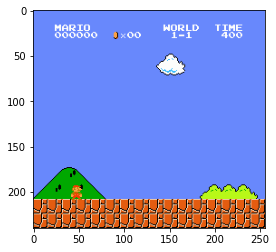

In [ ]:

# env = gym.make(env_name)
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

action_space = env.action_space.n
state_space = env.observation_space.shape[0]
state = env.reset()
state = torch.from_numpy(state.copy()).type(torch.float)

# print("state",state,state.shape)
action = env.action_space.sample() # Take a random action
observation, reward, done, info = env.step(action)
# print(observation)
display = Display(visible=0, size=(1400, 900))
display.start()
screen = env.render(mode='rgb_array')

import matplotlib.pyplot as plt
plt.imshow(screen)
# plt.imshow(screen[:,:,0])
plt.grid(False)
print(screen.shape) #(400, 600, 3)


KeyboardInterrupt: ignored

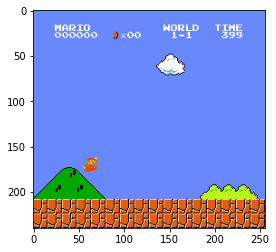

In [ ]:
import matplotlib.pyplot as plt

# env = gym.make("LunarLander-v2")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

from IPython import display
# https://stackoverflow.com/questions/50107530/how-to-render-openai-gym-in-google-colab
for i in range(200):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')
  plt.imshow(screen)
#   ipythondisplay.clear_output(wait=True)
#   ipythondisplay.display(plt.gcf())
  display.display(plt.gcf())
  display.clear_output(wait=True)
  if done:
    break

# ipythondisplay.clear_output(wait=True)
env.close()

59 5


KeyboardInterrupt: ignored

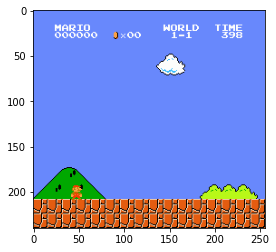

In [ ]:
import matplotlib.pyplot as plt
from IPython import display

cx = torch.zeros(1, 256)
hx = torch.zeros(1, 256)

state = env.reset()
state = torch.from_numpy(state.copy()).type(torch.float)
frame=[]


while True:
# for x in range(500):
    cx = cx.data
    hx = hx.data

    value, logit, (hx, cx) = model((state.unsqueeze(0), (hx, cx)), icm = False)
    prob = F.softmax(logit)
    action = prob.max(1)[1].data.numpy()
    state, reward, done, _ = env.step(action[0])
    state = torch.from_numpy(state.copy()).type(torch.float)






            # print("#####www####",Variable(state.unsqueeze(0)).dtype,(state.unsqueeze(0).dtype))
            value, logit, (hx, cx) = model((state.unsqueeze(0), (hx, cx)), icm = False)
            s_t = state
            # print("logit.size",logit.shape) # [1, 6]
            prob = F.softmax(logit, dim=1)
            log_prob = F.log_softmax(logit, dim=1)
            entropy = -(log_prob * prob).sum(1)
            entropies.append(entropy)
            # action = prob.multinomial().data
            action = prob.multinomial(1).data
            log_prob = log_prob.gather(1, action)
            oh_action = torch.Tensor(1, num_outputs)
            oh_action.zero_()
            oh_action.scatter_(1,action,1)
            a_t = oh_action
            actions.append(oh_action)
            print("action.numpy()",action.numpy())
            state, reward, done, _ = env.step(action.numpy()[0][0])
            state = torch.from_numpy(state.copy()).type(torch.float)

            # print("###o###",state.dtype)
            # state=state[:,:,0]

            done = done or episode_length >= max_episode_length
            reward = max(min(reward, 1), -1)
            s_t1 = state.float()
            # print("###st###",s_t.unsqueeze(0).dtype)
            # print("###vst###",Variable(s_t.unsqueeze(0)).dtype)
            vec_st1, inverse, forward = model((s_t.unsqueeze(0), s_t1.unsqueeze(0), a_t), icm = True)            

            reward_intrinsic = eta * ((vec_st1 - forward).pow(2)).sum(1) / 2.
            #reward_intrinsic = eta * ((vec_st1 - forward).pow(2)).sum(1).sqrt() / 2.
            # print("reward_intrinsic", reward_intrinsic.data.numpy())
            # reward_intrinsic = reward_intrinsic.data.numpy()[0][0]
            reward_intrinsic = reward_intrinsic.data.numpy()
            # print("ep ",x,", rwd ext: ", reward.item(), " ,rwd int: ", reward_intrinsic.item())
            print("ep ",x,", rwd ext: ", reward, " ,rwd int: ", reward_intrinsic.item())
            reward += reward_intrinsic









    screen = env.render(mode='rgb_array')
    frame.append(screen.copy())
    
    print(len(frame), action[0])
    plt.imshow(screen)
    display.display(plt.gcf())
    # display.clear_output(wait=True)
    display.clear_output(wait=False)

    if done:
        end_time = time.time()
        # print("Time {}, episode reward {}, episode length {}".format(
        #     time.strftime("%Hh %Mm %Ss", time.gmtime(end_time - start_time)), reward_sum, episode_length))
        # result.append((reward_sum, end_time - start_time))
        reward_sum = 0
        episode_length = 0
        # actions.clear()
        env.reset()
# # ipythondisplay.clear_output(wait=True)
# env.close()

#### kutd

In [ ]:

frame=np.array(frame)
mesh = ax.pcolormesh(x,y,frame[0, :, :], cmap='magma', vmin=240, vmax=360)

def animate(i):
    mesh.set_array(frame[i, :-1, :-1].ravel()) #https://stackoverflow.com/questions/29009743/using-set-array-with-pyplot-pcolormesh-ruins-figure
    title.set_text('L = {0:2f}'.format(lum[i]))
    return mesh
fig, ax = plt.subplots()

from matplotlib.animation import FuncAnimation
anim = FuncAnimation(fig, animate, interval=400, frames=frame.shape[0], repeat=False)
from IPython.display import HTML
HTML(anim.to_html5_video())


NameError: ignored

In [ ]:
env = gym.make("LunarLander-v2")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

from IPython import display
# https://stackoverflow.com/questions/50107530/how-to-render-openai-gym-in-google-colab
for i in range(50):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')
  plt.imshow(screen)
#   ipythondisplay.clear_output(wait=True)
#   ipythondisplay.display(plt.gcf())
  display.display(plt.gcf())
  display.clear_output(wait=True)
  if done:
    break

# ipythondisplay.clear_output(wait=True)
env.close()

#### moniter dumnp

In [ ]:

# https://colab.research.google.com/drive/12osEZByXOlGy8J-MSpkl3faObhzPGIrB
from pathlib import Path
from IPython import display as ipythondisplay
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

from stable_baselines.common.vec_env import VecVideoRecorder, SubprocVecEnv, DummyVecEnv
# Record video
def record_video(env, model, video_length=500, prefix='', video_folder='videos/'):
    """ :param env_id: (str), model: (RL model), video_length: (int), prefix: (str), video_folder: (str) """
    # eval_env = DummyVecEnv([lambda: gym.make('BipedalWalker-v2')])
    eval_env = VecVideoRecorder(env, video_folder=video_folder,
        record_video_trigger=lambda step: step == 0, video_length=video_length, name_prefix=prefix)
    obs = eval_env.reset()
    for _ in range(video_length):
        action, _ = model.predict(obs)
        obs, _, _, _ = eval_env.step(action)
    eval_env.close()

# Display video
def show_videos(video_path='', prefix=''):
    html = []
    for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                        loop controls style="height: 400px;">
                        <source src="data:video/mp4;base64,{}" type="video/mp4" />
                    </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))







ModuleNotFoundError: ignored

In [ ]:

record_video(env, model, video_length=1500, prefix='ppo2-walker-50000')
show_videos('videos', prefix='ppo2-walker-50000')

NameError: ignored

In [ ]:

# https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t#scrollTo=8nj5sjsk15IT
from gym.wrappers import Monitor

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay loop controls style="height: 400px;">
          <source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env


ImportError: ignored

In [ ]:

# env = wrap_env(gym.make("MsPacman-v0"))
env = wrap_env(env)
observation = env.reset()

while True:
    env.render()
    #your agent goes here
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done: 
      break;
env.close()
show_video()


/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:565: UserWarning: WARN: The environment MsPacman-v0 is out of date. You should consider upgrading to version `v4`.
  f"The environment {id} is out of date. You should consider "
/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:98: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


NameError: ignored